# TinyGPT

**Author: Abraham R.**

The following notebook is an example of a really tiny GPT based model called TinyGPT.
You'll review the GPT architecture (transformer decoder) and implement the following tasks:

## TinyGPT Architecture

Tailored for the [NLP-II course](https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/CEIA-LLMIAG) as we deal with architectures and theory, this model consists of a **Mixture of Experts GPT**, equivalent to models like:
- DeepSeek
- Mistral

## Tasks

Using TinyGPT you need to implement the following modifications:


## Inference: Modify the generate function to:
- Greedy decoding (pick max probability token).
- Temperature sampling.
- top-k or top-p sampling.

### References
- [huggingface generate](https://huggingface.co/docs/transformers/main_classes/text_generation)

## Architecture:
- Make TinyGPT a Mixture of Experts (MoE) of at least 2 experts.

## What to expect?

- You'll manage to understand a depth implementation of a GPT model.
- Implement a MoE Layer to create a state-of-the art GPT model.
- Explore decoding algorithms for text generation.


### NOTE

Tokenization is out of scope, we'll use a simple yet ineffective character-based tokenizer.


In [106]:
import os
import math
import time
import torch
import httpx
import warnings
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch.optim import AdamW
from typing import Optional, List, Type
from dataclasses import dataclass, field
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader

from trainer import Trainer

In [107]:
# Suppress specific warnings
warnings.filterwarnings("ignore", message="Online softmax is disabled on the fly")
warnings.filterwarnings("ignore", message="Not enough SMs to use max_autotune_gemm mode")

## Downloading Dataset

In [ ]:
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = httpx.get(url)
text = response.text

print(f"Downloaded {len(text)} characters from {url}\n")

# Save the text to a file
if not os.path.exists("./docs"):
    os.makedirs("./docs")
with open("./docs/tinyshakespeare.txt", "w") as f:
    f.write(text)

print(f'Sample:\n{text[:250]}')

Downloaded 1115394 characters from https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

Sample:
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



## Character-based encoding

`SimpleCharTokenizer` implementa un tokenizador simple basado en caracteres individuales. Su propósito es transformar texto plano en una secuencia de IDs numéricos (tokens) y viceversa, lo cual es necesario para poder alimentar texto al modelo TinyGPT.

#### Funcionamiento:

- Al inicializar el tokenizador con un corpus (`text`), se construye un vocabulario único a partir de todos los caracteres distintos presentes en el texto.
- Se definen dos diccionarios:
  - `stoi` (string to index): asigna a cada carácter su índice único.
  - `itos` (index to string): permite recuperar el carácter original desde su índice.
- El método `encode(text_string)` convierte una cadena en una lista de IDs enteros, uno por carácter.
- El método `decode(token_ids)` reconstruye la cadena original a partir de una lista de IDs.

> **Nota:** Este enfoque es limitado ya que trabaja a nivel de caracteres sin entender palabras, contextos ni estructuras gramaticales.

In [109]:
class SimpleCharTokenizer:
    """
    A simple character-level tokenizer that handles encoding and decoding.
    This class builds a vocabulary from a given text and provides methods
    to convert strings to token IDs and vice-versa.
    """
    def __init__(self, text: str):
        """
        Initializes the tokenizer and builds the vocabulary.

        Args:
            text (str): The corpus to build the vocabulary from.
        """
        self.chars = sorted(list(set(text)))
        self.vocab_size = len(self.chars)
        self.stoi = {char: i for i, char in enumerate(self.chars)}
        self.itos = {i: char for char, i in self.stoi.items()}

    def encode(self, text_string: str) -> list[int]:
        """
        Encodes a string into a list of integer token IDs.

        Args:
            text_string (str): The input string to encode.

        Returns:
            list[int]: A list of corresponding token IDs.
        """
        return [self.stoi[char] for char in text_string]

    def decode(self, token_ids: list[int]) -> str:
        """
        Decodes a list of integer token IDs back into a string.

        Args:
            token_ids (list[int]): The list of token IDs to decode.

        Returns:
            str: The resulting decoded string.
        """
        return ''.join([self.itos[token_id] for token_id in token_ids])

In [110]:
tokenizer = SimpleCharTokenizer(text)

vocab_size = tokenizer.vocab_size
data = torch.tensor(tokenizer.encode(text), dtype=torch.long)

# Train/test split
split = int(0.9 * len(data))
train_data = data[:split]
val_data = data[split:]

## GPT Configuration

#### `MoEArgs`

Define los parámetros específicos para una capa **Mixture of Experts (MoE)**:
- `num_experts`: cantidad total de expertos disponibles.
- `num_experts_per_token`: número de expertos que se activan por cada token de entrada.

Estos parámetros serán utilizados para controlar cómo se enrutan los tokens a los distintos expertos durante el forward pass.

In [111]:
@dataclass
class MoEArgs():
    """
    MoE input arguments class.
    """
    num_experts : int = field(default=4)
    num_experts_per_token : int = field(default=2)

#### `GPTConfig`

Es la configuración principal del modelo GPT:
- `block_size`: tamaño de la secuencia de entrada (ventana de contexto).
- `batch_size`: cantidad de muestras por batch.
- `n_embd`: dimensión de los embeddings.
- `n_head`: número de *heads* de atención en cada capa.
- `n_layer`: cantidad de capas transformer.
- `dropout`: proporción de *dropout* aplicada durante el entrenamiento.
- `vocab_size`: tamaño del vocabulario (debe coincidir con el tokenizador).
- `bias`: indica si se usan biases en las capas lineales.
- `ff_class`: clase opcional que define la capa feed-forward (permite usar una capa MoE).
- `moe`: objeto `MoEArgs` que habilita y parametriza una capa MoE.

In [112]:
@dataclass
class GPTConfig:
    """
    Base class for GPT models.
    """
    block_size: int = 32
    batch_size: int = 512
    n_embd: int = 64
    n_head: int = 4
    n_layer: int = 2
    dropout: float = 0.1
    vocab_size: int = vocab_size
    bias: bool = True
    ff_class: Optional[Type[nn.Module]] = None
    moe : Optional[MoEArgs] = None

In [113]:
config = GPTConfig()
print(config.__dict__)

{'block_size': 32, 'batch_size': 512, 'n_embd': 64, 'n_head': 4, 'n_layer': 2, 'dropout': 0.1, 'vocab_size': 65, 'bias': True, 'ff_class': None, 'moe': None}


## Creación de datasets y dataloaders

La clase `CharDataset` define un `Dataset` custom de PyTorch para entrenar modelos de lenguaje autoregresivos a nivel carácter. Recibe como entrada un `Tensor` unidimensional con los IDs de tokens (generados por el tokenizador) y construye pares entrada-objetivo adecuados para entrenamiento.

#### Funcionamiento:

- **Inicialización (`__init__`)**:  
  Se recibe el corpus como un `Tensor` de IDs de caracteres (`data`) y un `block_size` que define el tamaño de ventana de contexto que se le mostrará al modelo.

- **Longitud (`__len__`)**:  
  Calcula cuántas secuencias de entrenamiento se pueden extraer del corpus. Como cada par entrada-objetivo usa `block_size + 1` posiciones, el total de muestras posibles es `len(data) - block_size`.

- **Acceso a muestras (`__getitem__`)**:  
  Dado un índice `idx`, se devuelve un par:
  - `x`: secuencia de entrada de longitud `block_size`.
  - `y`: misma secuencia desplazada una posición a la derecha, que representa el objetivo de predicción siguiente carácter a carácter.

Este esquema es estándar para tareas de modelado de lenguaje autoregresivo, donde se entrena al modelo para predecir el próximo token dado un historial previo.

In [114]:
class CharDataset(Dataset):
    """
    A PyTorch Dataset for character-level language modeling.

    This dataset takes a long sequence of token IDs and creates overlapping
    input-target pairs of a specified block size, suitable for training
    autoregressive language models.
    """
    def __init__(self, data: torch.Tensor, block_size: int):
        """
        Initializes the dataset.

        Args:
            data (torch.Tensor): A 1D tensor of token IDs representing the entire corpus.
            block_size (int): The sequence length for each input sample (context window).
        """
        self.data = data
        self.block_size = block_size

    def __len__(self):
        """
        Returns the total number of possible sequences in the dataset.

        The length is calculated as the total number of tokens minus the `block_size`.
        This is because the `__getitem__` method needs to access up to index
        `idx + block_size` for the input `x` and `idx + block_size + 1` for the target `y`.
        Subtracting `block_size` ensures that even for the last possible `idx`, we do
        not go out of bounds when creating a sample.
        """
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        """
        Retrieves a sample from the dataset at the given index.

        Each sample consists of an input sequence (x) and a target sequence (y).
        The target sequence is the input sequence shifted by one position to the right,
        which is the standard for next-token prediction tasks.

        Args:
            idx (int): The starting index of the sequence in the data tensor.

        Returns:
            tuple[torch.Tensor, torch.Tensor]: A tuple containing the input
            tensor (x) and the target tensor (y).
        """
        x = self.data[idx : idx + self.block_size]
        y = self.data[idx + 1 : idx + self.block_size + 1]
        return x, y

#### Datasets

Se instancian dos objetos `CharDataset`, uno para entrenamiento (`train_dataset`) y otro para validación (`val_dataset`), utilizando los tensores `train_data` y `val_data` junto con el tamaño de ventana `block_size` definido en `config`.

In [115]:
train_dataset = CharDataset(train_data, config.block_size)
val_dataset = CharDataset(val_data, config.block_size)

#### DataLoaders

Se crean `train_loader` y `val_loader`, que son los iteradores utilizados durante el entrenamiento del modelo:

- `batch_size`: se toma de la configuración (`config.batch_size`).
- `shuffle`: activado para entrenamiento (mezcla aleatoria de secuencias), desactivado para validación (evaluación determinista).
- `drop_last`: descarta el último batch si es incompleto.
- `pin_memory`: acelera la transferencia de datos al GPU.
- `num_workers`: número de subprocesos para cargar datos.

In [116]:
train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers= 8, # if using mps set num_workers as 0.
)
val_loader = DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    drop_last=True,
    pin_memory=True,
    num_workers= 8,
)

## Módulo `AttentionHead`: Scaled Dot-Product

Este módulo implementa una **cabeza de atención** individual del mecanismo de atención múltiple (*Multi-Head Attention*) de los Transformers. Es la unidad básica encargada de calcular **atención causal** sobre una secuencia, lo que permite que cada token "observe" otros tokens anteriores y así incorporar contexto.

#### Fundamento teórico

La atención por producto punto escalado es una función que toma tres vectores por token: `query`, `key`, y `value`. La atención se calcula como:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^\top}{\sqrt{d_k}}\right)V
$$

Donde:

- $Q \in \mathbb{R}^{T \times d_k}$: vector de consulta.
- $K \in \mathbb{R}^{T \times d_k}$: vector clave.
- $V \in \mathbb{R}^{T \times d_v}$: vector valor.
- $d_k$: dimensión de las keys, se utiliza para escalar el producto punto y evitar gradientes explosivos.\\
- $T$: longitud de la secuencia.

En GPT, usamos atención *causal*: cada token sólo puede "ver" a los tokens anteriores (no a los futuros), lo que se aplica con una **máscara triangular inferior**.

#### Implementación paso a paso

- **Inicialización (`__init__`)**:
  - `head_dim`: dimensión interna de esta cabeza de atención (es decir, una fracción de `n_embd`).
  - `key_query_value`: proyección lineal que genera de forma conjunta los tres vectores necesarios (`k`, `q`, `v`) a partir de la entrada.
  - `dropout`: regularización aplicada sobre los pesos de atención.
  - `tril`: máscara triangular inferior ($ \text{tril}(1) $) para forzar atención causal.

- **Forward pass (`forward`)**:
  1. `x` es de forma `(B, T, C)`, donde:
    - `B` es el tamaño del batch (cantidad de secuencias procesadas en paralelo),
    - `T` es la longitud de cada secuencia (número de tokens, igual a `block_size`),
    - `C` es la dimensión del embedding para cada token (igual a `n_embd`).

  2. Se proyecta `x` a los tres espacios: keys (`k`), queries (`q`) y values (`v`), con una sola capa lineal.
  3. Si se proporciona una `kv_cache`, se concatenan las nuevas claves/valores con las almacenadas previamente (útil para generación autoregresiva eficiente).
  4. Se calcula el producto punto escalado ($qk^\top / \sqrt{d_k}$) → genera una matriz de pesos de atención.
  5. Se aplica la máscara para atención causal: impide que cada posición atienda a posiciones futuras.
  6. Se aplica `softmax` y `dropout` para normalizar y regularizar los pesos.
  7. Finalmente, se multiplican los pesos por los valores para obtener la salida de atención: una representación contextualizada de cada token.

- **Salidas**:
  - Si `return_weights=True`, devuelve también los pesos de atención (útil para visualización).
  - Si se usa `kv_cache`, también devuelve el nuevo cache (necesario para inferencia paso a paso en generación de texto).
  - En caso contrario, devuelve sólo la salida de atención.

In [117]:
class AttentionHead(nn.Module):
    """
    Scaled Dot-Product Attention Head for Multi-Head Attention.
    """
    def __init__(self, args: GPTConfig) -> None:
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.head_dim = args.n_embd // args.n_head

        # Combined QKV projection
        self.key_query_value = nn.Linear(args.n_embd, 3 * self.head_dim, bias=args.bias)

        self.dropout = nn.Dropout(args.dropout)
        self.block_size = args.block_size
        self.register_buffer('tril', torch.tril(torch.ones(args.block_size, args.block_size)))

    def forward(self, x: torch.Tensor, kv_cache: Optional[torch.Tensor] = None, return_weights=False):
        B, T, C = x.shape
        key_query_value = self.key_query_value(x)  # (B, T, 3 * head_dim)
        k, q, v = torch.chunk(key_query_value, 3, dim=-1)  # (B, T, head_dim) each

        if kv_cache is not None:
            key_cache, value_cache = kv_cache.unbind(dim=0)  # (B, T', head_dim)
            k = torch.cat((key_cache, k), dim=1)
            v = torch.cat((value_cache, v), dim=1)

        # Scaled dot-product attention
        wei = q @ k.transpose(-2, -1) * (self.head_dim ** -0.5)  # (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        out = wei @ v  # (B, T, head_dim)

        if return_weights:
            return out, wei

        if kv_cache is not None:
            return out, torch.stack((k, v))

        return out, None

#### Flujo de datos en cabeza de atención:

1. **Entrada completa**:  
   Cada token entra al sistema como un vector completo de dimensión `n_embd`.  
   Por ejemplo, si `n_embd = 64`, cada token es un vector de 64 valores.

2. **Proyección a Q, K, V**:  
   A través de una capa lineal (`nn.Linear`), cada token se transforma en tres vectores:
   - `query`
   - `key`
   - `value`  
   Todos de dimensión `n_embd`.

3. **División entre cabezas**:  
   Luego, estos vectores se **dividen entre las `n_head` cabezas** de atención:
   - Cada cabeza recibe una **fracción del espacio transformado**, no del embedding original.
   - La dimensión por cabeza es:  
      $$
      \text{head\_dim} = \frac{n\_embd}{n\_head}
      $$

4. **Atención sobre la secuencia**:  
   Cada cabeza hace atención **entre todos los tokens de la secuencia**, pero **usando sólo su subespacio** (`head_dim`) para cada token.  
   Es decir, **cada token es atendido completamente por cada cabeza**, pero desde una perspectiva distinta del espacio de representación.

#### ¿Por qué se hace esto?

- Para permitir que distintas cabezas aprendan **patrones complementarios**.
- Para distribuir el costo computacional: en lugar de hacer una sola atención de gran dimensión, se hacen varias en paralelo de menor dimensión.
- Por eso es necesario cumplir:

  ```python
  assert n_embd % n_head == 0
  ```

  Ya que cada cabeza debe recibir una fracción entera de la dimensión total.

Cada cabeza ve **todos los tokens**, pero en **distinto subespacio**.

## Módulo `MultiHeadAttention`

Este componente implementa el mecanismo de **atención multi-cabeza** del Transformer. La idea teórica es aplicar varias cabezas de atención en paralelo para capturar distintas relaciones entre tokens desde diferentes subespacios de representación.

> **Importante:** en esta implementación, las cabezas **no se computan en paralelo** sino **de forma secuencial** mediante un bucle `for`. Esto mejora la claridad del código, pero **no es eficiente** para uso en producción. En implementaciones reales (como Hugging Face), se vectoriza todo el cálculo para que las cabezas se procesen simultáneamente.

#### ¿Qué hace este módulo?

- Crea múltiples instancias del módulo `AttentionHead`, una por cada cabeza definida en `n_head`.
- Cada cabeza realiza atención de forma independiente sobre toda la secuencia.
- Las salidas de todas las cabezas se concatenan y se proyectan nuevamente al espacio de dimensión completa `n_embd`.

#### Paso a paso del `__init__`

1. **Verificación de divisibilidad**:  
   Se asegura que `n_embd` pueda dividirse equitativamente entre `n_head`, para calcular la dimensión de cada cabeza (`head_dim`).
2. **Creación de las cabezas de atención**:  
   Se construye una `nn.ModuleList` con `n_head` instancias de `AttentionHead`.
3. **Proyección final**:  
   Una capa lineal (`self.proj`) toma el vector concatenado de todas las cabezas y lo proyecta de vuelta a la dimensión original (`n_embd`).  
   Esto permite mezclar la información aprendida por cada cabeza.
4. **Dropout final**:  
   Regularización aplicada a la salida final para mitigar overfitting.

#### Paso a paso del `forward`

##### Entradas:
- `x`: secuencia de tokens embebida, de forma `(B, T, n_embd)`.
- `kv_cache`: opcional, para reutilizar las claves/valores de pasos anteriores (modo generación).
- `return_weights`: si se activa, también devuelve los pesos de atención por cabeza.

##### Proceso:
1. Se itera sobre cada cabeza (`self.heads`):
   - Cada cabeza recibe la secuencia completa.
   - Produce una salida de atención `out` para esa cabeza.
   - (Opcional) Se acumulan los pesos de atención y los nuevos cachés de `k/v` si corresponde.
2. Las salidas individuales de todas las cabezas (`out`) se **concatenan a lo largo de la dimensión de embedding**:
   $$
   \text{concat} \in \mathbb{R}^{B \times T \times n\_embd}
   $$
3. Se aplica la proyección lineal final y el dropout.

##### Salidas:
- La salida principal tiene forma `(B, T, n_embd)`.
- Si `return_weights=True`, también devuelve los pesos de atención por cabeza (`[n_head, B, T, T]`).
- Si hay `kv_cache`, también devuelve el nuevo caché para reutilización.

#### ¿Por qué usar múltiples cabezas?

- **Diversidad de representaciones**: cada cabeza ve la misma secuencia, pero en un subespacio diferente (porción del embedding), y por lo tanto puede aprender a detectar relaciones diferentes entre tokens.
- **Paralelismo**: se computan todas las cabezas simultáneamente, lo que es eficiente en hardware moderno.
- **Potencia expresiva**: concatenar las salidas de distintas cabezas produce una representación más rica y contextualizada de cada token.

In [118]:
class MultiHeadAttention(nn.Module):
    def __init__(self, args: GPTConfig):
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.n_heads = args.n_head
        self.head_dim = args.n_embd // args.n_head

        self.heads = nn.ModuleList([
            AttentionHead(args) for _ in range(self.n_heads)
        ])

        self.proj = nn.Linear(args.n_embd, args.n_embd, bias=args.bias)
        self.dropout = nn.Dropout(args.dropout)

    def forward(self, x, kv_cache=None, return_weights=False):
        all_outputs = []
        all_weights = []
        new_kv_cache = [] if kv_cache is not None else None

        for i, head in enumerate(self.heads):
            head_cache = kv_cache[i] if kv_cache is not None else None
            out, weights_or_kv = head(x, kv_cache=head_cache, return_weights=return_weights)
            all_outputs.append(out)
            if return_weights:
                all_weights.append(weights_or_kv)
            if kv_cache is not None:
                new_kv_cache.append(weights_or_kv)  # weights_or_kv is new kv_cache here

        concat = torch.cat(all_outputs, dim=-1)  # concat along embedding dim
        out = self.dropout(self.proj(concat))

        if return_weights:
            return out, torch.stack(all_weights)
        if kv_cache is not None:
            return out, new_kv_cache
        return out

## Módulos `FeedForward` y `Block`: Bloque Transformer

### `FeedForward`: Red totalmente conectada

Este módulo implementa la red densa que sigue a la atención en cada bloque Transformer.

#### Arquitectura:

- Una primera capa lineal expande la dimensión:  
  $$
  n\_embd \rightarrow 4 \cdot n\_embd
  $$
- Se aplica una función no lineal (`ReLU`).
- Se proyecta de vuelta a la dimensión original:  
  $$
  4 \cdot n\_embd \rightarrow n\_embd
  $$
- Se incluye `Dropout` como regularización.

Esta estructura es estándar en Transformers, y sirve para **transformar localmente** (por token) la información contextualizada tras la atención.

In [119]:
class FeedForward(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout),
        )

    def forward(self, x):
        return self.net(x)

### `Block`: Bloque Transformer completo

Este módulo representa una capa completa del modelo GPT. Está compuesto por:

1. **Capa de normalización previa a la atención (`ln1`)**:
   - Se aplica antes de la atención (pre-norm).

2. **Atención multi-cabeza (`self.attn`)**:
   - Procesa la secuencia completa con múltiples cabezas de atención.
   - Puede retornar también los pesos de atención (`return_weights=True`).
   - Puede recibir y actualizar un caché `kv_cache` (útil para inferencia autoregresiva).

3. **Skip connection 1**:
   - La salida de la atención se **suma** a la entrada original (`x + attn_out`).

4. **Normalización previa a la red feed-forward (`ln2`)**.

5. **Red feed-forward (`self.ff`)**:
   - Por defecto usa `FeedForward`, pero puede ser reemplazada por una variante como `MoE` si se especifica en `GPTConfig`.

6. **Skip connection 2**:
   - La salida del feed-forward se **suma** al resultado anterior.

#### Flujo completo del `forward`:

```python
x = x + self.attn(self.ln1(x))
x = x + self.ff(self.ln2(x))
```

Este diseño de **pre-norm + skip connection** es clave para la estabilidad de modelos profundos.

#### Notas adicionales

- `ff_class` permite inyectar una clase alternativa a `FeedForward`, por ejemplo, una capa Mixture of Experts (MoE). Esto da flexibilidad para experimentar sin modificar el núcleo del bloque.
- `kv_cache` se propaga y actualiza para habilitar inferencia eficiente en generación paso a paso.

> **Resumen:** Este módulo encapsula un bloque completo de GPT, combinando atención contextual con transformación no lineal por token. Apilar múltiples de estos bloques permite al modelo aprender dependencias complejas en la secuencia.


En esta implementación (`Block`) estamos siguiendo la variante **Pre-Norm**, que difiere del diseño original del paper *"Attention is All You Need"*. A continuación se detalla la diferencia clave.

- En el paper original se utiliza el esquema **Post-Norm**:
  - La operación de atención o feed-forward se aplica primero.
  - Luego se suma la conexión residual.
  - Finalmente se aplica `LayerNorm`.

<p align="center">
    <img src="imgs/paper_block.png" alt="Arquitectura del bloque Transformer Decoder"><br>
    <em>Figura 2: Bloque Transformer Decoder con esquema Post-Norm (según el paper original).</em>
</p>

  $$
  \text{Output} = \text{LayerNorm}(x + \text{SubLayer}(x))
  $$

  Este diseño es visible en los bloques etiquetados como `Add & Norm` en la figura del paper.

- En esta implementación (`Block`) se aplica **Pre-Norm**, una variante moderna:
  - Primero se normaliza la entrada (`LayerNorm`).
  - Luego se aplica el submódulo (atención o feed-forward).
  - Finalmente se suma la conexión residual.

<p align="center">
    <img src="imgs/block.png" alt="Arquitectura del bloque Transformer Decoder"><br>
    <em>Figura 1: Bloque Transformer Decoder con esquema Pre-Norm (implementación actual).</em>
</p>

  $$
  \text{Output} = x + \text{SubLayer}(\text{LayerNorm}(x))
  $$

Hoy en día se prefiere Pre-Norm debido a que:

- Mejora la **estabilidad de entrenamiento** en redes profundas.
- Permite mayor facilidad para entrenar modelos grandes (como GPT-2, GPT-3, LLaMA, Mistral).
- Es el enfoque estándar en arquitecturas *decoder-only* modernas como GPT.

In [120]:
class Block(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = MultiHeadAttention(config)

        ff_class = config.ff_class if config.ff_class is not None else FeedForward
        self.ff = ff_class(config)

    def forward(self, x, kv_cache=None, return_weights=False):
        attn_out = self.attn(self.ln1(x), kv_cache=kv_cache, return_weights=return_weights)
        if return_weights:
            attn_out, weights = attn_out
        else:
            weights = None

        if isinstance(attn_out, tuple):
            attn_out, updated_kv = attn_out
        else:
            updated_kv = None

        x = x + attn_out
        x = x + self.ff(self.ln2(x))
        return (x, updated_kv, weights) if return_weights else (x, updated_kv)

## TinyGPT Architecture

Este módulo implementa un modelo completo de tipo **GPT**, basado exclusivamente en bloques decoder del Transformer. Es una arquitectura autoregresiva entrenada para predecir el próximo token dado un historial previo.

<p align="center">
    <img src="imgs/tinygpt.png" alt="Arquitectura de TinyGPT"><br>
    <em>Figura 3: Arquitectura de TinyGPT.</em>
</p>

### Componentes principales (`__init__`)

1. **Embedding de tokens (`token_emb`)**:
   - Convierte los índices enteros de tokens en vectores densos de dimensión `n_embd`.

2. **Embedding posicional (`pos_emb`)**:
   - Aprende una representación específica para cada posición de la secuencia (desde 0 hasta `block_size - 1`).
   - Se suma al embedding de cada token para incorporar información de orden.

3. **Bloques Transformer (`blocks`)**:
   - Se crea una `nn.ModuleList` con `n_layer` instancias del bloque `Block` (que contiene atención, normalización, y feedforward).
   - Cada bloque procesa la secuencia enriqueciendo la representación contextual de los tokens.

4. **Normalización final (`ln_f`)**:
   - Una capa `LayerNorm` que se aplica antes de la salida final para estabilizar la distribución de activaciones.

5. **Cabeza de predicción (`head`)**:
   - Proyección lineal que convierte la salida de cada token en un vector del tamaño del vocabulario (`vocab_size`).
   - Es la que produce los **logits**, sobre los cuales se aplicará `softmax` para obtener probabilidades de predicción.

### Flujo del `forward`

#### Entradas:
- `idx`: tensor `(B, T)` con los índices de tokens para cada secuencia del batch.
- `kv_cache`: caché opcional para claves y valores (útil para generación paso a paso).
- `return_weights`: si se activa, también devuelve los pesos de atención por cada capa y cabeza.

#### Pasos:

1. **Token y posición**:
   - Se obtiene el embedding de cada token: `tok_emb = token_emb(idx)`
   - Se generan los índices de posición `0..T-1` y se embeben: `pos_emb = pos_emb(pos)`
   - Se suman ambos embeddings:  
     $$
     x = \text{token\_emb} + \text{pos\_emb}
     $$

2. **Paso por bloques Transformer**:
   - Se itera secuencialmente sobre los bloques.
   - En cada uno, se actualiza `x` y, si aplica, se recolectan pesos de atención y nuevos `kv_cache`.

3. **Postprocesamiento y salida**:
   - Se aplica la `LayerNorm` final.
   - Se proyecta a logits con la capa final:  
     $$
     \text{logits} = \text{head}(x)
     $$

#### Salidas:
- Si `return_weights=True`:  
  Retorna `(logits, [kv_cache], [attention_weights])`
- Si `kv_cache` está presente:  
  Se propaga a lo largo del modelo para acelerar la inferencia.
- En modo normal:  
  Solo retorna `logits` con forma `(B, T, vocab_size)`

In [121]:
class TinyGPT(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.token_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Embedding(config.block_size, config.n_embd)
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.config = config

    def forward(self, idx, kv_cache=None, return_weights=False):
        B, T = idx.shape
        tok_emb = self.token_emb(idx)
        pos = torch.arange(T, device=idx.device)
        pos_emb = self.pos_emb(pos)[None, :, :]
        x = tok_emb + pos_emb

        new_kv_cache = [] if kv_cache is not None else None
        all_weights = [] if return_weights else None

        for i, block in enumerate(self.blocks):
            layer_kv = kv_cache[i] if kv_cache is not None else None
            if return_weights:
                x, updated_kv, weights = block(x, kv_cache=layer_kv, return_weights=True)
                all_weights.append(weights)  # weights shape: (n_heads, B, T, T)
            else:
                x, updated_kv = block(x, kv_cache=layer_kv)
            if kv_cache is not None:
                new_kv_cache.append(updated_kv)

        x = self.ln_f(x)
        logits = self.head(x)

        if return_weights:
            if kv_cache is not None:
                return logits, new_kv_cache, all_weights
            else:
                return logits, all_weights
        else:
            if kv_cache is not None:
                return logits, new_kv_cache
            return logits

## Generation function (inference)

### Función `generate`: generación autoregresiva de texto con TinyGPT

Esta función implementa la lógica de generación secuencial de tokens usando el modelo `TinyGPT`, a partir de un prompt inicial. El modelo predice un token a la vez, lo agrega a la secuencia, y vuelve a invocarse sobre la nueva secuencia para predecir el siguiente.

#### Decorador `@torch.no_grad()`

Se desactiva el cálculo de gradientes ya que no se está entrenando el modelo sino haciendo inferencia. Esto:
- Ahorra memoria.
- Acelera la ejecución.

#### Flujo general

1. Preparación del prompt:
   - Se tokeniza el string inicial (`prompt`) usando el `tokenizer`.
   - Se convierte en un tensor de `dtype=torch.long`, con forma `(1, T_init)`.

2. Inicialización opcional del cache:
   - `kv_cache = None`: se usará para almacenar claves y valores anteriores si `use_cache=True`.

3. Loop de generación:
   - Se repite hasta generar `max_new_tokens` tokens nuevos.

   ##### Dentro del loop:
   - Se define `idx_cond`, que es el contexto de entrada:
     - Si `use_cache=True`: se pasa solo el último token generado (`idx[:, -1:]`).
     - Si no: se pasa el último bloque de contexto (`idx[:, -block_size:]`), útil si el contexto excede la ventana.
   - Se ejecuta el modelo con ese contexto y el `kv_cache`.
   - Se actualiza `kv_cache` si es que está habilitado.
   - Se obtiene la distribución de probabilidad sobre el próximo token:
     $$
     \text{probs} = \text{softmax}(logits_{t})
     $$
   - Se muestrea el próximo token usando `torch.multinomial`.
   - Se concatena ese token a la secuencia `idx`.

4. Decodificación final:
   - Se convierte la secuencia generada de IDs de vuelta a texto con `tokenizer.decode`.

#### Características importantes

- Autoregresivo: genera token por token, usando solo información pasada.
- Soporte para cache (`kv_cache`):
  - Evita recalcular la atención sobre todos los tokens previos en cada paso.
  - Aumenta significativamente la eficiencia en inferencia.
- Sampling estocástico:
  - Se usa `torch.multinomial` para muestrear según la distribución de probabilidad, generando resultados no deterministas.

In [122]:
@torch.no_grad()
def generate(model: torch.nn.Module, prompt: str, max_new_tokens: int = 100, use_cache: bool = True, device: torch.device = torch.device("cpu")):
    model.eval()
    idx = torch.tensor(tokenizer.encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        probs = F.softmax(logits[:, -1, :], dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, next_token), dim=1)

    return tokenizer.decode(idx[0].tolist())

# Setup

Configuración del dispositivo, modelo, optimizador y parámetros de entrenamiento

Este bloque inicializa el modelo `TinyGPT` y define todos los elementos necesarios para su entrenamiento.

```python
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
```

- Se selecciona el dispositivo óptimo disponible:
  - `cuda`: GPU NVIDIA con soporte CUDA.
  - `mps`: GPU de Apple Silicon mediante Metal Performance Shaders.
  - `cpu`: como último recurso.

```python
m = TinyGPT(config).to(device)
model = torch.compile(m)
```

- Se instancia el modelo con la configuración `config`.
- Se mueve al dispositivo seleccionado (`.to(device)`).
- Se aplica `torch.compile(model)` (si usás PyTorch 2+):
    - Esta función transforma dinámicamente el modelo a una forma optimizada.
    - Puede mejorar significativamente el rendimiento durante entrenamiento e inferencia.
    - Internamente hace "tracing" del grafo de operaciones.

```python
optimizer = AdamW(model.parameters(), lr=1e-3)
```

- Se utiliza el optimizador AdamW (Adam con weight decay).
- lr=1e-3`es una tasa de aprendizaje relativamente alta, pero puede estabilizarse con scheduler.
- AdamW es una elección estándar en entrenamiento de Transformers.

```python
# scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
total_steps = len(train_loader) * epochs
scheduler = CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=1e-5)
```

- La tasa de aprendizaje disminuye suavemente desde `lr` hasta `eta_min` siguiendo una curva coseno.
- `T_max` define la cantidad total de pasos de entrenamiento (épocas × batches).
- Esta estrategia es más estable que `StepLR`, evita saltos bruscos en el `lr`, y suele mejorar la capacidad de generalización.
- `eta_min` asegura que el `lr` no decaiga hasta cero completamente, lo que ayuda a mantener aprendizaje activo hasta el final.

```python
loss_fn = torch.nn.CrossEntropyLoss()
```

- Se usa `CrossEntropyLoss`, que es equivalente a aplicar `log-softmax` seguido de `negative log-likelihood`.
- Es la función estándar para clasificación multi-clase, y se usa aquí para predecir el próximo token.

```python
epochs = 20
```

- Se define un entrenamiento de 20 épocas.

In [123]:
# Device to use
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f'Using device: {device}')

# Model
m = TinyGPT(config).to(device)
model = torch.compile(m)

Using device: cuda


In [124]:
# Epochs
epochs = 20

# Optimizer, scheduler, and loss function
optimizer = AdamW(model.parameters(), lr=1e-3)
# scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
total_steps = len(train_loader) * epochs
scheduler = CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Training

Este bloque ejecuta el entrenamiento del modelo `TinyGPT` utilizando una clase `Trainer` que encapsula el loop de entrenamiento, la evaluación y el manejo de checkpoints.

```python
trainer = Trainer(
    model=model,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./vanilla_checkpoints",
    save_every_n=500
)
```

- Recibe todos los componentes del pipeline: modelo, dataloaders, función de pérdida, optimizador y scheduler.
- Soporta:
  - Gradient accumulation (`gradient_accumulation_steps`).
  - Mixed Precision Training (AMP).
  - Checkpointing automático (cada `save_every_n` pasos y al final).
  - Evaluación después de cada época.

La función `train_and_evaluate()` encapsula el ciclo completo de entrenamiento y evaluación de un modelo `Trainer`:

```python
def train_and_evaluate(
    trainer,
    epochs: int,
    use_amp: bool = True,
    dtype=torch.bfloat16,
    plot: bool = True,
    save_csv_path: str = None,
) -> pd.DataFrame:
    ...
```

- Calcula métricas por época: `loss`, `perplexity`, `time`.
- Las guarda en un `DataFrame`.
- Puede graficar los resultados y exportarlos a `.csv`.
- Separa completamente la lógica de entrenamiento del control externo.


La función `plot_metrics()` grafica métricas a lo largo de las épocas:

```python
def plot_metrics(df: pd.DataFrame):
    ...
```

- Requiere como entrada un `DataFrame` con las columnas: `epoch`, `train_loss`, `val_loss`, `train_ppl`, `val_ppl`.
- Produce dos gráficos: evolución de pérdida y evolución de perplejidad.
- Usa `matplotlib` para visualización clara y comparativa.

Estas funciones mejoran la trazabilidad del entrenamiento y te permiten auditar el progreso del modelo con métricas objetivas y visuales.

In [125]:
def plot_metrics(df: pd.DataFrame):
    """Grafica curvas de pérdida y perplejidad."""
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(df['epoch'], df['train_loss'], label='Train Loss')
    plt.plot(df['epoch'], df['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(df['epoch'], df['train_ppl'], label='Train Perplexity')
    plt.plot(df['epoch'], df['val_ppl'], label='Validation Perplexity')
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.title('Perplexity per Epoch')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


def train_and_evaluate(
    trainer,
    epochs: int,
    use_amp: bool = True,
    dtype=torch.bfloat16,
    plot: bool = True,
    save_csv_path: Optional[str] = None,
) -> pd.DataFrame:
    """
    Entrena el modelo y evalúa por cada época. Retorna un DataFrame con las métricas.

    Args:
        trainer (Trainer): Instancia del trainer ya configurada.
        epochs (int): Número de épocas a entrenar.
        use_amp (bool): Si se usa precisión mixta.
        dtype (torch.dtype): Tipo de dato a usar en AMP.
        plot (bool): Si se grafican las curvas de loss y perplexity.
        save_csv_path (str): Ruta para guardar el CSV con métricas. None = no guardar.

    Returns:
        pd.DataFrame: Tabla con métricas por época.
    """
    train_losses, val_losses = [], []
    train_ppls, val_ppls = [], []
    for epoch in range(epochs):
        start = time.time()
        train_loss = trainer.train_model_v2(use_amp=use_amp, dtype=dtype)
        train_ppl = math.exp(train_loss)
        val_loss = trainer.eval_model()
        val_ppl = math.exp(val_loss)
        end = time.time()
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_ppls.append(train_ppl)
        val_ppls.append(val_ppl)
        print(
            f"\nEpoch {epoch+1:02d} | "
            f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
            f"Train PPL: {train_ppl:.2f} | Val PPL: {val_ppl:.2f} | "
            f"Time: {(end-start):.2f}s\n"
        )
    # Crear DataFrame con resultados
    df = pd.DataFrame({
        'epoch': list(range(1, epochs + 1)),
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_ppl': train_ppls,
        'val_ppl': val_ppls
    })
    # Guardar en CSV si se solicita
    if save_csv_path:
        df.to_csv(save_csv_path, index=False)
    # Graficar si se solicita
    if plot:
        plot_metrics(df)
    return df

In [126]:
train_model = False

Loading model weights from checkpoint ./vanilla_checkpoints/checkpoint_final.pt


Metrics loaded from CSV.


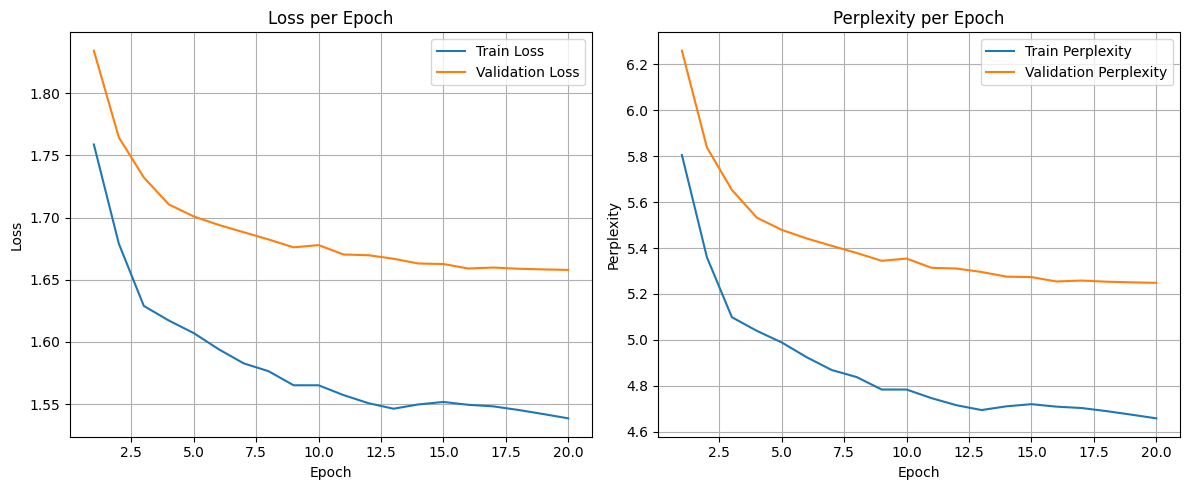

In [127]:
if not train_model and os.path.exists("./vanilla_checkpoints/checkpoint_final.pt"):
    checkpoint_path = "./vanilla_checkpoints/checkpoint_final.pt"
    print(f"Loading model weights from checkpoint {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    if os.path.exists("./vanilla_checkpoints/metrics.csv"):
        df_metrics = pd.read_csv("./vanilla_checkpoints/metrics.csv")
        print("Metrics loaded from CSV.")
        plot_metrics(df_metrics)
    else:
        print("No metrics CSV found.")
else:
    print("Training the model")
    trainer = Trainer(
        model=model,
        train_data_loader=train_loader,
        test_data_loader=val_loader,
        loss_fn=loss_fn,
        gradient_accumulation_steps=1,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        save_dir="./vanilla_checkpoints",
        save_every_n=500
    )
    df_metrics = train_and_evaluate(trainer, epochs=epochs, save_csv_path='./vanilla_checkpoints/metrics.csv')



#### Análisis de la evolución de pérdida y perplejidad (20 épocas)

Se entrenó el modelo `TinyGPT` durante 20 épocas utilizando un `batch_size = 512`, lo cual permitió una utilización eficiente de GPU (hasta 98% de UTL) sin comprometer estabilidad ni generar errores de memoria. La siguiente figura muestra la evolución de la pérdida y la perplejidad en los conjuntos de entrenamiento y validación.

- La pérdida de entrenamiento (`train_loss`) desciende consistentemente hasta estabilizarse cerca de 1.53.
- La pérdida de validación (`val_loss`) se estabiliza en torno a 1.65, sin mejoras significativas a partir de la época 15.
- El comportamiento de la perplejidad (`perplexity`) es coherente con las curvas de pérdida: desciende hasta estabilizarse en valores cercanos a:
  - 4.6 en entrenamiento,
  - 5.2 en validación.

#### Entrenamiento previo: 30 épocas

Antes de este entrenamiento se realizó una corrida con 30 épocas, tras la cual se observó el inicio de overfitting, identificado por los siguientes signos:

- La pérdida de validación comenzó a aumentar levemente después de la época 20.
- Mientras tanto, la pérdida de entrenamiento seguía disminuyendo, generando una brecha creciente entre `train_loss` y `val_loss`.
- El modelo comenzó a memorizar mejor el corpus de entrenamiento, pero sin mejorar su capacidad de generalización.

Este patrón es característico de sobreajuste, especialmente en modelos pequeños entrenados con corpus limitados y sin técnicas de regularización explícita.

#### Conclusión

Entrenar por 20 épocas resultó ser el punto óptimo de equilibrio entre aprendizaje efectivo y prevención del sobreajuste. Los resultados indican que el modelo ha capturado patrones significativos del corpus sin comprometer su capacidad de generalización. La decisión de limitar a 20 épocas se basa en evidencia empírica observada tanto en las curvas de pérdida como en la perplejidad.

## Quick test 

In [128]:
generate(model=model, prompt="To be", max_new_tokens=100, use_cache=True, device=device) 

'To be a gods.\n\nVOLUMNIA:\nThy geners,\nTell heaven the lights for where rument.\n\nCOMINIUS:\nPresed much deli'

# Task I

Using TinyGPT you need to implement the following modifications:


## Inference: Modify the generate function to:
- Greedy decoding (pick max probability token).
- Temperature sampling.
- top-k or top-p sampling.

### References
- [huggingface generate](https://huggingface.co/docs/transformers/main_classes/text_generation)



In [129]:
@torch.no_grad()
def generateV2(
    model: torch.nn.Module,
    prompt: str,
    max_new_tokens: int = 100,
    use_cache: bool = True,
    temperature: float = 1.0,
    top_k: int = 0,
    top_p: float = 1.0,
    verbose: bool = False,
    device: torch.device = torch.device("cpu")
) -> Optional[str]:
    """
    Autoregressive text generation with decoding strategies.

    Args:
        model (torch.nn.Module): The model to use for generation.
        prompt (str): Initial text prompt.
        max_new_tokens (int): Number of tokens to generate.
        use_cache (bool): Whether to use KV cache.
        temperature (float): Scaling factor for logits; <= 0 disables sampling.
        top_k (int): Keep only top-k tokens with highest probability (0 = disable).
        top_p (float): Nucleus sampling: keep top tokens with cumulative probability ≤ top_p (1.0 = disable).
        verbose (bool): If True, prints additional information during generation.
    device (torch.device): Device to run the model on (e.g., 'cpu', 'cuda', 'mps').

    Returns:
        str: The generated text including the prompt.
    """
    assert not (top_k > 0 and top_p < 1.0), "Use either top_k or top_p, not both"
    model.eval()
    idx = torch.tensor(tokenizer.encode(prompt), dtype=torch.long)[None, :].to(device)
    assert idx.shape[0] == 1, "Only supports batch size 1 for now"
    kv_cache = None
    for _ in range(max_new_tokens):
        # Context input
        idx_cond = idx[:, -1:] if (use_cache and kv_cache is not None) else idx[:, -config.block_size:]        
        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)
        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None
        logits = logits[:, -1, :]  # shape: (B=1, vocab_size)        
        # Apply temperature
        if temperature > 0:
            logits = logits / temperature
            probs = F.softmax(logits, dim=-1)
            # Top-k sampling
            if top_k > 0:
                top_k_values, top_k_indices = torch.topk(probs, top_k)
                top_k_probs = top_k_values / top_k_values.sum(dim=-1, keepdim=True)
                # Select the index from the top_k indices
                ix = torch.multinomial(top_k_probs, num_samples=1)
                next_token = top_k_indices.gather(1, ix).squeeze(1)        
            # Top-p sampling
            elif top_p < 1.0:
                sorted_probs, sorted_indices = torch.sort(probs, descending=True)
                cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
                # Remove tokens with cumulative probability above the threshold
                sorted_indices_to_remove = cumulative_probs > top_p
                # Shift the indices to the right to keep the first token above the threshold
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
                probs[indices_to_remove] = 0
                next_token = torch.multinomial(probs, num_samples=1).squeeze(1)
            # Plain temperature sampling
            else:
                next_token = torch.multinomial(probs, num_samples=1)[0]
        else:
            # Greedy decoding (argmax)
            next_token = torch.argmax(logits, dim=-1)
        # Append new token
        if verbose:
            print(f"Next token: {tokenizer.decode([next_token.item()])} (ID: {next_token.item()})")
        idx = torch.cat((idx, next_token.unsqueeze(0)), dim=1)
    return tokenizer.decode(idx[0].tolist())


## Compare generate vs generateV2

Add your comments and findings

In [130]:
result_default = generate(model=model, prompt="One fire burns out another", max_new_tokens=50, use_cache=True, device=device)
result_t0 = generateV2(model=model, prompt="One fire burns out another", max_new_tokens=50, use_cache=True, temperature=0, device=device)
result_topk = generateV2(model=model, prompt="One fire burns out another", max_new_tokens=50, use_cache=True, temperature=0.7, top_k=10, device=device)
result_topp = generateV2(model=model, prompt="One fire burns out another", max_new_tokens=50, use_cache=True, temperature=0.7, top_p=0.9, device=device)

print(f"> Result using generate():\n{result_default}")
print("\n" + "-" * 20 + "\n")
print(f"> Result using generateV2() with temperature 0:\n{result_t0}")
print("\n" + "-" * 20 + "\n")
print(f"> Result using generateV2() with temperature 0.7 and top_k=10:\n{result_topk}")
print("\n" + "-" * 20 + "\n")
print(f"> Result using generateV2() with temperature 0.7 and top_p=0.9:\n{result_topp}")

> Result using generate():
One fire burns out another'd heirs
Wall of the vitch promised him for,
And f

--------------------

> Result using generateV2() with temperature 0:
One fire burns out another that the straight the straight the straight the s

--------------------

> Result using generateV2() with temperature 0.7 and top_k=10:
One fire burns out another's love
And man, and three the before his molest m

--------------------

> Result using generateV2() with temperature 0.7 and top_p=0.9:
One fire burns out another find thee but of your as with of his holy call be


Se realizaron pruebas de generación de texto utilizando distintas configuraciones de decodificación sobre el modelo `TinyGPT`, dadas las mismas condiciones iniciales:

- Prompt: `"One fire burns out another"`
- Tokens generados: `50`
- Uso de cache activado (`use_cache=True`)

Se compararon cuatro configuraciones:

1. `generate()`: versión original por defecto.
2. `generateV2()` con `temperature=0` (decodificación greedy determinista).
3. `generateV2()` con `temperature=0.7` y `top_k=10`.
4. `generateV2()` con `temperature=0.7` y `top_p=0.9`.

#### Observaciones generales

- Todas las variantes generan palabras válidas en inglés, lo cual indica que el modelo ha aprendido una representación estadística coherente del lenguaje incluso con una tokenización a nivel carácter.
- En todas las variantes, el texto generado muestra una cierta estructura sintáctica, incluyendo puntuación correcta, nombres propios, signos de exclamación o cambio de hablante, lo que sugiere que el modelo aprendió patrones estructurales básicos.


#### `temperature=0` (greedy decoding)

- La generación es completamente determinista.
- Se observa que el modelo tiende a entrar en repeticiones tras algunos tokens, repitiendo ciertas secuencias sin control.
- Este comportamiento es típico en decodificación greedy en modelos pequeños o poco regulares: al elegir siempre el token más probable, se cae fácilmente en bucles locales de alta probabilidad.


#### `temperature=0.7` + `top_k=10`

- La generación muestra más variabilidad y cambios de tema o hablante, lo que sugiere mayor diversidad léxica.
- Se logra un buen balance entre coherencia y creatividad: aparecen palabras y estructuras no triviales, pero sin degenerar en ruido aleatorio.
- Esta configuración es útil cuando se quiere mantener un control razonable del contenido, pero con diversidad controlada.


#### `temperature=0.7` + `top_p=0.9`

- También genera frases con variedad léxica, aunque con un comportamiento más continuo y fluido, sin cortes abruptos como los que a veces produce `top_k`.
- El enfoque nucleus sampling permite incluir tokens de probabilidad no máxima si pertenecen al "núcleo" semántico de alta probabilidad, lo que favorece la fluidez.


#### Conclusión

A pesar de la simpleza del modelo (TinyGPT con tokenización carácter a carácter), las estrategias de decodificación tienen un impacto directo en la calidad, diversidad y coherencia del texto generado.

- `temperature=0` puede llevar a repeticiones y texto plano.
- `temperature > 0` combinado con `top_k` o `top_p` produce resultados más ricos y variados.

## Task II
- Make TinyGPT a Mixture of Experts (MoE) of at least 2 experts.

En esta sección se definen los dos bloques fundamentales para construir un módulo Mixture of Experts (MoE) dentro del modelo `TinyGPT`: los expertos y el mecanismo de gating.

#### `Expert`: red neuronal individual

- Representa un experto MLP independiente, con una arquitectura similar al bloque feedforward tradicional de un Transformer.
- Está compuesto por una secuencia lineal → ReLU → lineal → dropout.
- Opera sobre tensores de forma `(N, D)` donde `N` es el número de tokens y `D` es la dimensión del embedding.
- Recibe tokens ya aplanados desde la capa `MoELayer` y devuelve la misma forma tras aplicar la red.
- Este bloque puede ser instanciado múltiples veces para formar un conjunto de expertos que trabajen en paralelo (aunque no necesariamente todos son activados para cada input).

#### `Gate`: red de selección de expertos

- Este módulo actúa como un mecanismo de enrutamiento que decide qué expertos deben activarse para cada token.
- Para cada vector de embedding de entrada, produce un vector de logits de tamaño `num_experts`.
- Estas salidas pueden ser convertidas a probabilidades (por ejemplo, con softmax o top-k) para determinar cómo combinar la salida de los expertos o seleccionar los más relevantes.

Ambas clases (`Expert` y `Gate`) son componentes reutilizables y modulares, y juntas forman la base del bloque MoE que será integrado en la arquitectura general del modelo `TinyGPT`.

En los siguientes pasos se implementará un mecanismo de enrutamiento y combinación que hará uso de estas dos clases para construir una capa `MoEFFN`.

In [131]:
class Expert(nn.Module):
    """
    An expert MLP instance from within a MoE.
    """

    def __init__(self, config: GPTConfig) -> None:
        """
        Initiates expert MLP given dimensions/hidden dimensions.
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout)
        ) ## Example network

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the expert MLP.

        Args:
            x (torch.Tensor): Input tensor of shape (N, D) where N is number of tokens, D is embedding dimension.

        Returns:
            torch.Tensor: Output tensor of shape (N, D) after passing through the MLP.
        """
        # Input is already flattened (N, D) when coming from MoELayer
        return self.net(x)


class Gate(nn.Module):
    """
    MoE gating network MLP.
    """

    def __init__(self, config: GPTConfig):
        super().__init__()
        self.proj = nn.Linear(config.n_embd, config.moe.num_experts)

    def forward(self, x):
        """
        Forward pass through the MoE gating network.

        This method applies a linear projection to the input tensor to produce
        logits for each expert. The output shape is (B, T, num_experts), where
        B is batch size, T is sequence length, and num_experts is the number of experts.

        The logits can be used to determine the weights for each expert in the MoE layer.

        Args:
            x (torch.Tensor): Input tensor of shape (B, T, D), where B is batch size, T is sequence length, and D is embedding dimension.

        Returns:
            torch.Tensor: Output tensor of shape (B, T, num_experts) containing the logits for each expert.
        """
        return self.proj(x)

Este módulo define la capa principal de tipo Mixture of Experts (MoE). Su función es aplicar múltiples expertos `MLP` en paralelo y decidir, de manera inteligente, qué subconjunto de expertos usar por cada token.

La capa está compuesta por:
- Una lista de expertos (`nn.ModuleList`) independientes.
- Una red de gating (`Gate`) que determina a qué experto debe ir cada token.
- Un mecanismo de ruteo basado en top-k selección dura (hard top-k routing).

#### Funcionamiento detallado

1. Aplanamiento del input:
   - Se transforma el input `(B, T, D)` en una matriz 2D `(N, D)` donde `N = B × T`, para tratar cada token como una unidad independiente.

2. Cálculo de scores por experto:
   - Cada token es evaluado por la red de gating para producir un vector de logits sobre los expertos → `(N, E)`, donde `E` es la cantidad total de expertos.

3. Selección top-k de expertos:
   - Para cada token se seleccionan los `k` expertos más relevantes según los logits.

4. Procesamiento distribuido:
   - Cada experto recibe únicamente los tokens que le fueron asignados por el ruteo top-k.
   - La salida de cada experto se redistribuye en sus posiciones originales en el tensor de salida.

5. Combinación y normalización:
   - En caso de que un token sea procesado por más de un experto, las salidas se suman y se promedian para mantener la escala de activación estable.

#### Observaciones

- Este diseño implementa un ruteo duro y disperso, lo cual:
  - Reduce el cómputo (cada token es procesado solo por `k < E` expertos).
  - Favorece la especialización de expertos en diferentes regiones del espacio de representación.
- En esta implementación, el ruteo es determinista dentro de cada forward (no usa muestreo estocástico).


In [132]:
class MoELayer(nn.Module):
    """
    Mixture of experts FeedForward Layer
    """

    def __init__(self, experts : List[nn.Module], gate : nn.Module, moe_args : MoEArgs):
        super().__init__()
        self.experts = nn.ModuleList(experts)
        self.gate = gate
        self.args = moe_args

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for the Mixture of Experts (MoE) layer.

        This layer distributes each token's representation to a subset of experts,
        determined by a gating network. Specifically:

        1. Each token (of shape D) is passed through the gate to obtain a score for each expert.
        2. The top-k experts with the highest scores are selected per token.
        3. Each expert processes only the tokens routed to it.
        4. The outputs are gathered and combined in their original positions.

        This implementation uses top-k hard routing, with optional overlapping of tokens across experts.

        Args:
            x (torch.Tensor): Input tensor of shape (B, T, D), where B is batch size, T is sequence length, and D is embedding dimension.

        Returns:
            torch.Tensor: Output tensor of shape (B, T, D) after processing through the experts.
        
        Note:
            - The output is additive in case multiple experts are used for a token.
            - The output is averaged by the number of experts per token to maintain scale.
        """
        B, T, D = x.shape
        x_flat = x.view(B * T, D)  # Flatten to (N, D), where N = B*T
        # Step 1: Compute expert logits for each token
        logits = self.gate(x_flat)  # (N, E), where E = number of experts
        # Step 2: Select top-k experts per token
        topk = self.args.num_experts_per_token
        topk_scores, topk_indices = torch.topk(logits, k=topk, dim=-1)  # (N, k)
        # Step 3: Initialize output buffer
        out = torch.zeros_like(x_flat)  # (N, D)
        # Step 4: For each expert, gather inputs, process, and scatter outputs
        for expert_idx, expert in enumerate(self.experts):
            # Boolean mask where token routed to this expert
            mask = (topk_indices == expert_idx)  # (N, k)
            selected = mask.any(dim=-1).nonzero(as_tuple=False).squeeze(-1)  # (n_selected,)
            if selected.numel() == 0:
                continue  # Skip unused expert
            # Gather selected inputs
            x_selected = x_flat[selected]  # (n_selected, D)
            # Forward pass through expert
            out_selected = expert(x_selected)  # (n_selected, D)
            # Scatter outputs back to their positions
            out[selected] += out_selected  # Note: additive in case of multiple expert usage
        # Divide by number of experts per token to average
        out = out / topk  # (N, D)        
        # Step 5: Reshape back to (B, T, D)
        return out.view(B, T, D)

Este módulo define la capa `MoEFFN`, que reemplaza al bloque de tipo `FeedForward` tradicional utilizado dentro de cada bloque Transformer. En lugar de una única red MLP, se utiliza una Mixture of Experts (MoE), permitiendo una computación más especializada y selectiva por token.

#### ¿Qué hace esta clase?

- Crea una instancia de `MoELayer`, que contiene:
  - Una lista de expertos independientes (`Expert`), cada uno con su propio MLP.
  - Un módulo de gating (`Gate`), que determina qué expertos deben activarse por cada token.
  - La lógica de ruteo top-k, configurable vía `config.moe`.
- Implementa un `forward()` que simplemente reenvía el input a través del `MoELayer`.

#### Ventajas del enfoque

- Introduce diversidad de expertos, donde diferentes tokens pueden activar diferentes rutas de cómputo.
- Permite que los expertos se especialicen en distintos subespacios del embedding.
- Escalable: se puede ajustar fácilmente el número de expertos y el número de expertos por token.

In [133]:
class MoEFFN(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.moe = MoELayer(  
            experts=[Expert(config) for _ in range(config.moe.num_experts)],
            gate=Gate(config),
            moe_args=config.moe
        )

    def forward(self, x):
        """
        Forward pass through the Mixture of Experts (MoE) FeedForward Network.

        This method applies the MoE layer to the input tensor. The MoE layer consists of
        multiple experts and a gating mechanism that routes tokens to the appropriate experts.

        The input tensor is expected to have shape (B, T, D), where:
        - B is the batch size,
        - T is the sequence length,
        - D is the embedding dimension.

        The output tensor will have the same shape as the input tensor, with each token
        processed by the selected experts based on the gating mechanism.

        Args:
            x (torch.Tensor): Input tensor of shape (B, T, D).

        Returns:
            torch.Tensor: Output tensor of the same shape (B, T, D) after passing through the MoE layer.
        """
        return self.moe(x)

## Adding MoE to Config

In [134]:
config.ff_class = MoEFFN
config.moe = MoEArgs(num_experts=4, num_experts_per_token=1)

# Training TinyGPT-MoE


In [135]:
m_moe = TinyGPT(config).to(device)
model_moe = torch.compile(m_moe)

In [136]:
# Epochs
epochs = 20

# Optimizer, scheduler, and loss function
optimizer = AdamW(model_moe.parameters(), lr=1e-3)
# scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
total_steps = len(train_loader) * epochs
scheduler = CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

Loading model weights from checkpoint ./moe_checkpoints/checkpoint_final.pt
Metrics loaded from CSV.


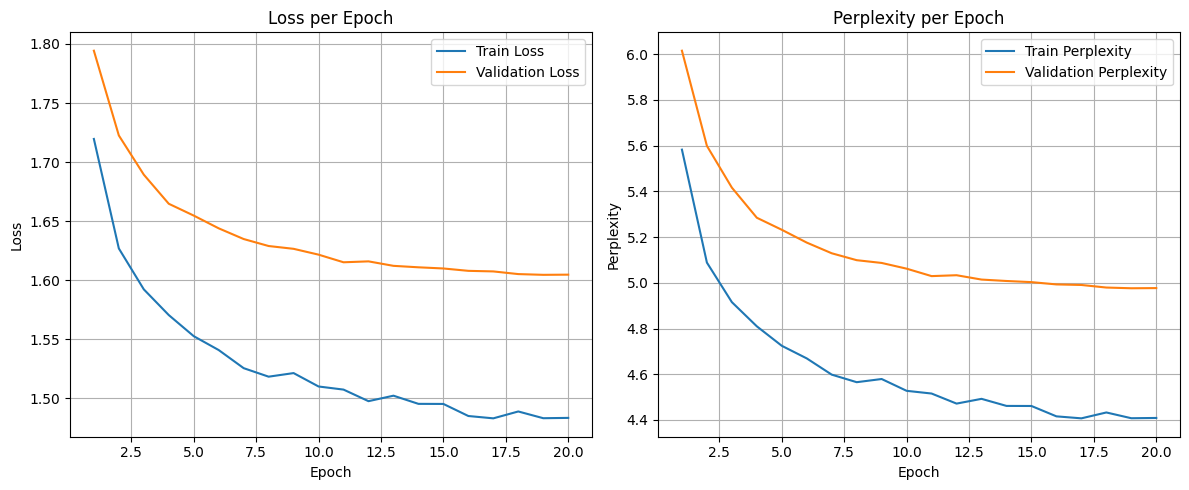

In [137]:
if not train_model and os.path.exists("./moe_checkpoints/checkpoint_final.pt"):
    checkpoint_path = "./moe_checkpoints/checkpoint_final.pt"
    print(f"Loading model weights from checkpoint {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model_moe.load_state_dict(checkpoint["model_state_dict"])
    if os.path.exists("./moe_checkpoints/metrics.csv"):
        df_metrics = pd.read_csv("./moe_checkpoints/metrics.csv")
        print("Metrics loaded from CSV.")
        plot_metrics(df_metrics)
    else:
        print("No metrics CSV found.")
else:
    print("Training the model")
    trainer = Trainer(
        model=model_moe,
        train_data_loader=train_loader,
        test_data_loader=val_loader,
        loss_fn=loss_fn,
        gradient_accumulation_steps=1,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        save_dir="./moe_checkpoints",
        save_every_n=500
    )
    df_metrics = train_and_evaluate(trainer, epochs=epochs, save_csv_path='./moe_checkpoints/metrics.csv')

#### Análisis de la evolución de pérdida y perplejidad – Modelo con Mixture of Experts (MoE)

Se entrenó el modelo `TinyGPT` con una arquitectura basada en Mixture of Experts (MoE), utilizando 4 expertos y 1 experto activado por token (`top-k = 1`), durante 20 épocas. El entrenamiento se realizó con un `batch_size = 512`, logrando una alta utilización de GPU sin provocar errores de memoria. La figura muestra la evolución de la pérdida (`loss`) y la perplejidad (`perplexity`) en los conjuntos de entrenamiento y validación.

- La pérdida de entrenamiento descendió rápidamente durante las primeras épocas, estabilizándose cerca de 1.48 hacia el final.
- La pérdida de validación también mostró una tendencia decreciente, pero con una pendiente más suave, estabilizándose cerca de 1.60.
- La perplejidad se redujo progresivamente, alcanzando aproximadamente:
  - 4.4 en entrenamiento,
  - 5.0 en validación.

No se observan signos de overfitting: las curvas de validación siguen la tendencia general sin incremento abrupto ni divergencia marcada respecto a las curvas de entrenamiento.

#### Comparación con el modelo base sin MoE

Respecto al modelo sin MoE, los resultados del modelo con expertos muestran:

- Una mejor pérdida de entrenamiento (1.48 vs. 1.53) y validación (1.60 vs. 1.65).
- Una menor perplejidad tanto en entrenamiento (4.4 vs. 4.6) como en validación (5.0 vs. 5.2).

Esto sugiere que introducir especialización en capas feed-forward a través de expertos mejora la capacidad expresiva del modelo, permitiendo una mejor adaptación al corpus sin incurrir en sobreajuste.

#### Conclusión

El uso de MoE ha demostrado ser beneficioso en términos de pérdida y perplejidad. El modelo logra mejor rendimiento general con la misma cantidad de épocas que el modelo base, validando empíricamente que la especialización por expertos puede ser útil incluso en arquitecturas pequeñas como `TinyGPT`.

## Comparing both models

In [138]:
generateV2(model=model, prompt="To be", max_new_tokens=100, use_cache=True, temperature=1, top_k=3, device=device) 

'To be the storm of the will be to him thee,\nAnd stand that thou hast\nThanks and shalt stand the content.\n'

In [139]:
generateV2(model=model_moe, prompt="To be", max_new_tokens=100, use_cache=True, temperature=1, top_k=3, device=device)

'To be too strike to the prince of my service as in the senators of men the service.\n\nLADY CAPULET:\nThat s'

Ambos modelos, tanto el estándar como el que incorpora MoE, generan textos con un nivel de coherencia local aceptable, aunque sin una semántica clara ni fluidez sostenida. La comparación directa revela lo siguiente:

- **Sin MoE:** El texto generado mantiene estructuras gramaticales simples y repetitivas, con frases que presentan cierta cadencia pero carecen de sentido profundo.
  
- **Con MoE:** El modelo con MoE produce frases ligeramente más variadas en construcción, pero igualmente incoherentes desde un punto de vista semántico. Algunas combinaciones son incluso más ruidosas gramaticalmente.

En definitiva, **no se observa una mejora cualitativa clara** en el texto generado por el modelo con MoE respecto al modelo base. Ambos modelos fallan en generar secuencias con continuidad semántica o lógica, y operan más como generadores de patrones superficiales de lenguaje que como modelos con comprensión contextual.

## Visualizing Attention

As we know, a GPT has the task to complete text, let's see the attention maps generated by a pretrained model.

La función `visualize_attention` permite inspeccionar cómo el modelo TinyGPT distribuye su atención a nivel de caracteres durante la generación de texto. Es una herramienta clave para analizar el comportamiento del modelo entrenado y verificar si respeta el diseño esperado de un Transformer autoregresivo.

```python
@torch.no_grad()
def visualize_attention(model, prompt, max_len=10):
    ...
```

#### ¿Qué hace esta función?

1. Codifica el `prompt` carácter por carácter.
2. Realiza un `forward` con `return_weights=True` para obtener los pesos de atención*de todas las cabezas de todas las capas.
3. Para cada capa y cada cabeza, se grafica la matriz de atención:
   - Eje X: posición de las keys (tokens "mirados").
   - Eje Y: posición de las queries (tokens que "miran").
   - El valor en (i, j) indica cuánto mira el token `i` al token `j`.

#### Fundamento teórico

En un modelo Transformer causal con tokenización carácter a carácter:

- La entrada es una secuencia de IDs de caracteres (`a`, `b`, `c`, etc.).
- Cada cabeza de atención aprende a establecer conexiones entre posiciones anteriores de caracteres.
- El enmascaramiento causal (triangular inferior) impide que un token mire hacia adelante.
- A diferencia de modelos con tokenización semántica (como BPE o WordPiece), aquí no se capturan directamente relaciones entre palabras completas, sino patrones más bajos: fonéticos, morfológicos, estructurales o de puntuación.

#### ¿Qué esperar de la visualización?

- Patrones diagonales fuertes: lo esperable es que cada token atienda principalmente a los caracteres inmediatos anteriores. Esto se ve como una diagonal dominante desde la esquina superior izquierda hacia la inferior derecha, confirmando que el modelo sigue una atención secuencial.

- Variabilidad entre cabezas:
  - Algunas pueden enfocarse casi exclusivamente en el carácter previo (atención puntual).
  - Otras distribuyen atención más uniformemente sobre el contexto disponible, lo que ayuda a capturar prefijos, sufijos o estructuras repetitivas (ej: `ing`, `tion`, saltos de línea, etc.).

- Evolución a través de capas:
  - Las primeras capas tienden a mostrar atención más local (letras cercanas).
  - Las capas posteriores pueden exhibir patrones más largos o rítmicos, como atención a signos de puntuación distantes o bloques estructurales similares (por ejemplo: apertura y cierre de paréntesis, comillas, etc.).

Este tipo de visualización es especialmente útil cuando se trabaja con modelos simples, entrenados desde cero, ya que permite identificar tanto comportamientos esperados como anomalías o sesgos que pueden surgir durante el entrenamiento.

In [140]:
@torch.no_grad()
def visualize_attention(model, prompt, max_len=10):
    model.eval()
    idx = torch.tensor(tokenizer.encode(prompt), dtype=torch.long)[None, :].to(device)

    # Run forward with return_weights=True
    logits, all_weights = model(idx, return_weights=True)

    # all_weights is a list of length n_layers
    # each element: shape (n_heads, batch_size, seq_len, seq_len)
    # We'll visualize the first batch element only

    n_layers = len(all_weights)
    n_heads = all_weights[0].shape[0]
    seq_len = all_weights[0].shape[-1]

    for layer_i in range(n_layers):
        fig, axes = plt.subplots(1, n_heads, figsize=(5 * n_heads, 5))
        if n_heads == 1:
            axes = [axes]
        for head_i in range(n_heads):
            attn = all_weights[layer_i][head_i, 0].cpu()  # shape (seq_len, seq_len)
            im = axes[head_i].imshow(attn, cmap='viridis')
            axes[head_i].set_title(f'Layer {layer_i + 1} Head {head_i + 1}')
            axes[head_i].set_xlabel('Key Position')
            axes[head_i].set_ylabel('Query Position')
            axes[head_i].set_xticks(range(seq_len))
            axes[head_i].set_yticks(range(seq_len))
            fig.colorbar(im, ax=axes[head_i])
        plt.tight_layout()
        plt.show()


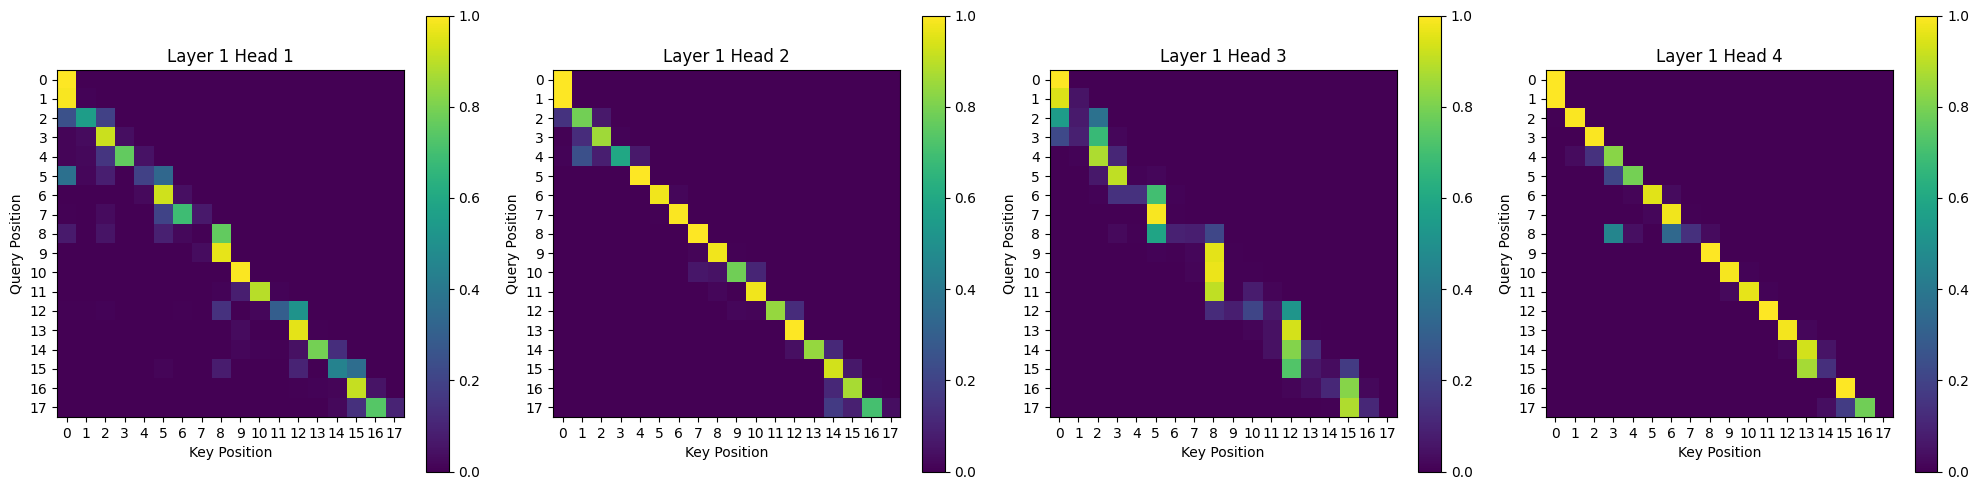

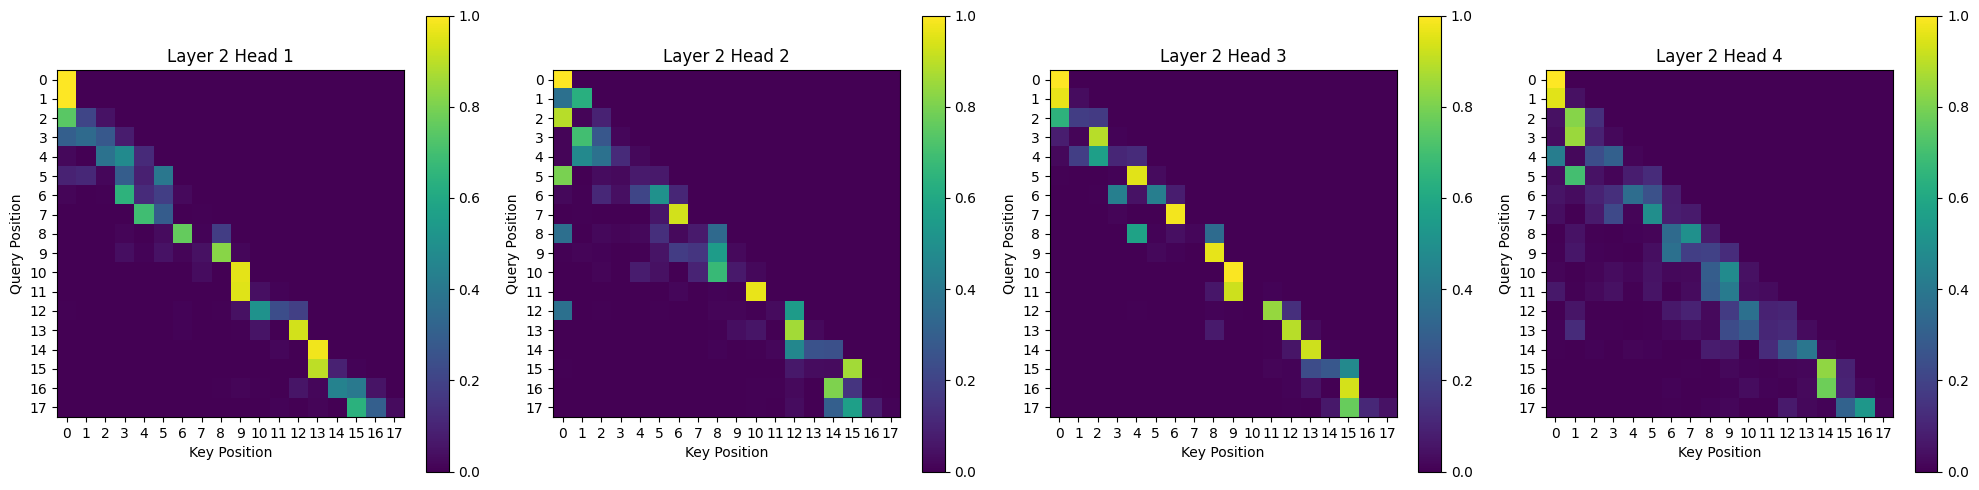

In [141]:
prompt = "To be or not to be"
visualize_attention(model, prompt)

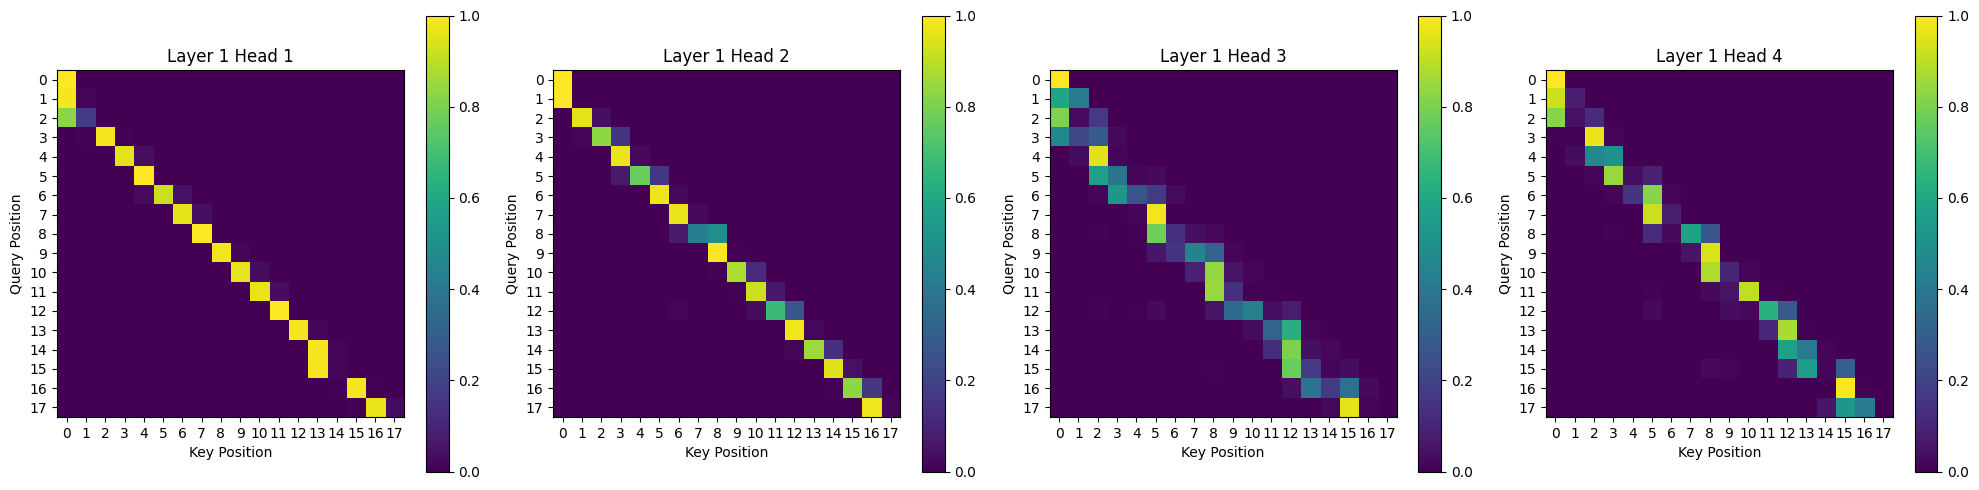

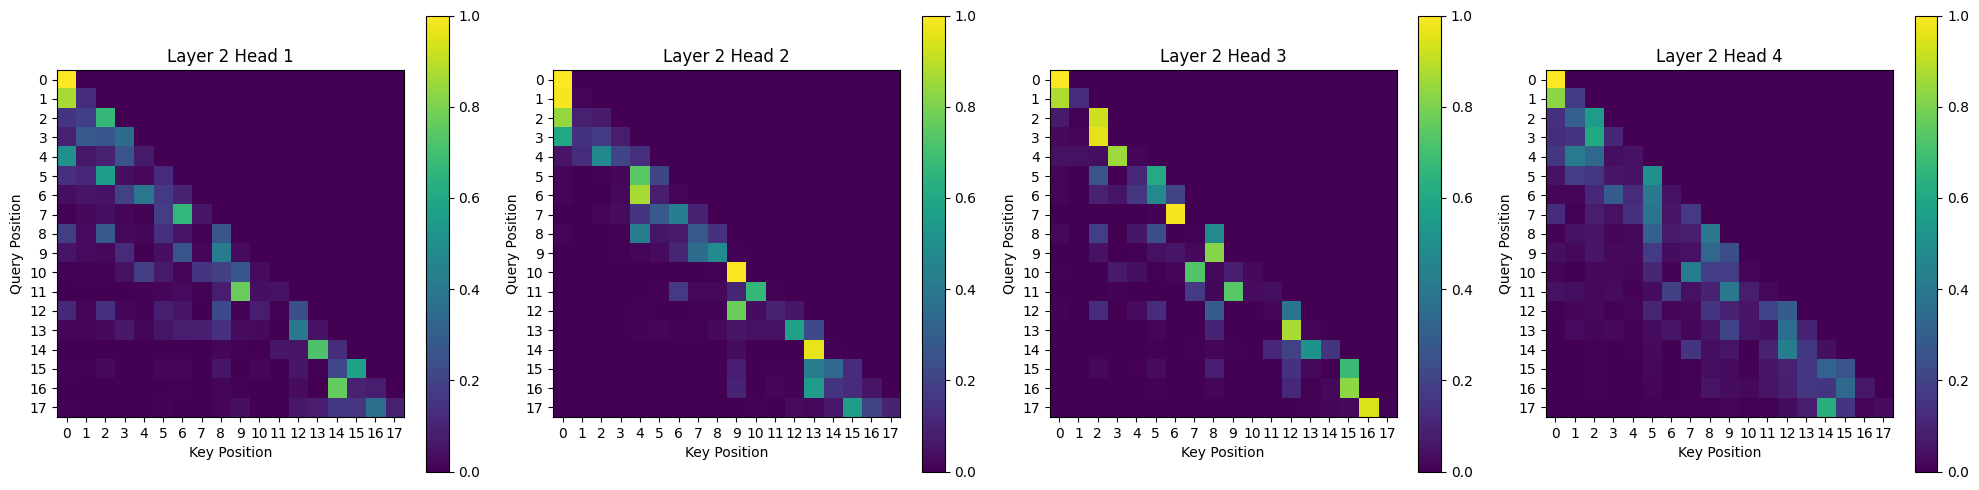

In [142]:
visualize_attention(model_moe, prompt)

## Conclusions

In [143]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Vanilla model parameters: {count_parameters(model)}")
print(f"MoE model parameters: {count_parameters(model_moe)}")

Vanilla model parameters: 110464
MoE model parameters: 309512


Durante el trabajo práctico se entrenaron dos variantes de TinyGPT sobre *tinyshakespeare.txt*: un Transformer con Feed-Forward denso (Dense) y otro con Mixture of Experts (MoE) (4 expertos, top-k=1 por token). En ambos casos se monitoreó loss y perplejidad por época para evaluar la evolución del aprendizaje.

El uso de un tokenizer carácter-a-carácter limitó la granularidad semántica aprendible. Aun así, los modelos captaron patrones estadísticos robustos: puntuación consistente, mayúsculas, nombres propios y cambios de hablante. Esta elección explica por qué las mejoras cuantitativas no siempre se traducen en saltos cualitativos notorios en el texto generado.

La función `generate()` se amplió para soportar greedy, temperature sampling y top-k/top-p. Todas las variantes produjeron palabras válidas en inglés y estructura sintáctica razonable. Con temperature=0 (greedy) se observaron repeticiones, mientras que temperature>0 con top-k/top-p redujo degeneraciones y añadió diversidad. Importante: *a igualdad de parámetros de decodificación*, las diferencias cualitativas entre Dense y MoE fueron sutiles; ambos mantienen coherencia local pero sin continuidad semántica prolongada, consistente con el tamaño del modelo y la tokenización por caracteres.

El modelo con uso de MoE superó al Dense en métricas:
- Parámetros: Dense ≈ 110,464 vs. MoE ≈ 309,512.
- Tendencia de entrenamiento/validación: el MoE logró loss y perplejidad más bajas (p. ej., ~1.48/4.4 en train y ~1.60/5.0 en val) que el Dense (~1.53/4.6 en train y ~1.65/5.2 en val).  
Estas diferencias indican que el ruteo a expertos habilita mayor capacidad efectiva con el mismo budget de cómputo por token, favoreciendo la especialización de submodelos MLP en patrones distintos del espacio de caracteres.

Con top-k=1, el MoE mantiene cómputo similar al Dense por token, pero aporta mayor ancho de parámetros y capacidad de especialización. En nuestro escenario, esa ganancia se reflejó en las curvas (loss/ppl), pero no generó un salto cualitativo equivalente en las muestras de texto. La razón principal es la escala (modelo pequeño) y la tokenización a nivel carácter, que acotan la transferencia de mejoras estadísticas a coherencia semántica visible.

- MoE: mejor eficiencia estadística (menor loss/ppl) y potencial de especialización sin multiplicar el cómputo por token.  
- Dense: arquitectura más simple y estable, con desempeño sólido para esta escala.  
- En la práctica de este TP, MoE es mejor cuantitativamente, pero las muestras generadas no muestran diferencias sustanciales frente a Dense bajo los mismos parámetros de decodificación.

Posibles próximos pasos:
- Sustituir la tokenización por subpalabras (BPE/WordPiece) para desbloquear mejoras cualitativas.
- Aumentar capacidad (n_embd, n_layer) y/o entrenar por más pasos con regularización de ruteo (p. ej., pérdidas de balanceo) para potenciar la especialización de expertos.
- Afinar decodificación (p. ej., top-p adaptativo) y evaluar con métricas cualitativas (diversidad, repetición, coherencia a largo alcance).